In [171]:
import numpy as np
import pandas as pd
from dca_oop import ARPS
import matplotlib.pyplot as plt

In [172]:
#inputs:
well_names_col="NPD_WELL_BORE_NAME"
well_name="15/9-F-14"
prod_col_name="BORE_OIL_VOL"
date_col_name="DATEPRD"

In [173]:
# function to load the data
def load_data(filepath , well_names_col ,well_name , prod_col_name , date_col_name):

     df= pd.read_excel(filepath,parse_dates=True)

    # filtring to the specific well
     df = df [ df[well_names_col] == well_name][[date_col_name,prod_col_name]]
   # rename columns
     df.columns = ["date","production"]


    # return the dataframe with only the two columns [ data , production ], and they must be with the same name
     return df

In [174]:
df = load_data("Volve production data.xlsx",well_names_col ,well_name , prod_col_name , date_col_name)
df.head()

,date,production
4967,2008-02-12,0.0
4968,2008-02-13,0.0
4969,2008-02-14,0.0
4970,2008-02-15,0.0
4971,2008-02-16,0.0


In [ ]:
df.plot(x="date",y="production")

In [ ]:
#inputs
window_size=100
stds=.5
# ================== FITTING INTERVAL (USER INPUTS) ==================
fit_start = "2009-05-01"   # inclusive
fit_end   = "2014-12-31"   # inclusive

In [ ]:
arps_all = ARPS(dataframe=df, production_col="production", date_column="date")
df_smoothed_all = arps_all.smooth(window_size=window_size, stds=stds, trim=True).copy()
df_smoothed_all["date"] = pd.to_datetime(df_smoothed_all["date"])

In [ ]:
min_points = 5

# --- build fit subset from the full smoothed data (dates + raw prod) ---
mask = (df_smoothed_all["date"] >= pd.to_datetime(fit_start)) & \
       (df_smoothed_all["date"] <= pd.to_datetime(fit_end))
df_fit = df_smoothed_all.loc[mask, ["date", "production"]].copy()
df_fit

In [ ]:
# safety check
if len(df_fit) < min_points:
    raise ValueError(f"Not enough data points in the fitting interval "
                     f"({len(df_fit)} found, need at least {min_points}).")

# --- re-fit and re-smooth ONLY the interval (so interval smoothing matches class logic) ---
arps_fit = ARPS(dataframe=df_fit, production_col="production", date_column="date")
df_fit_smoothed = arps_fit.smooth(window_size=window_size, stds=stds, trim=True).copy()
df_fit_smoothed["date"] = pd.to_datetime(df_fit_smoothed["date"])


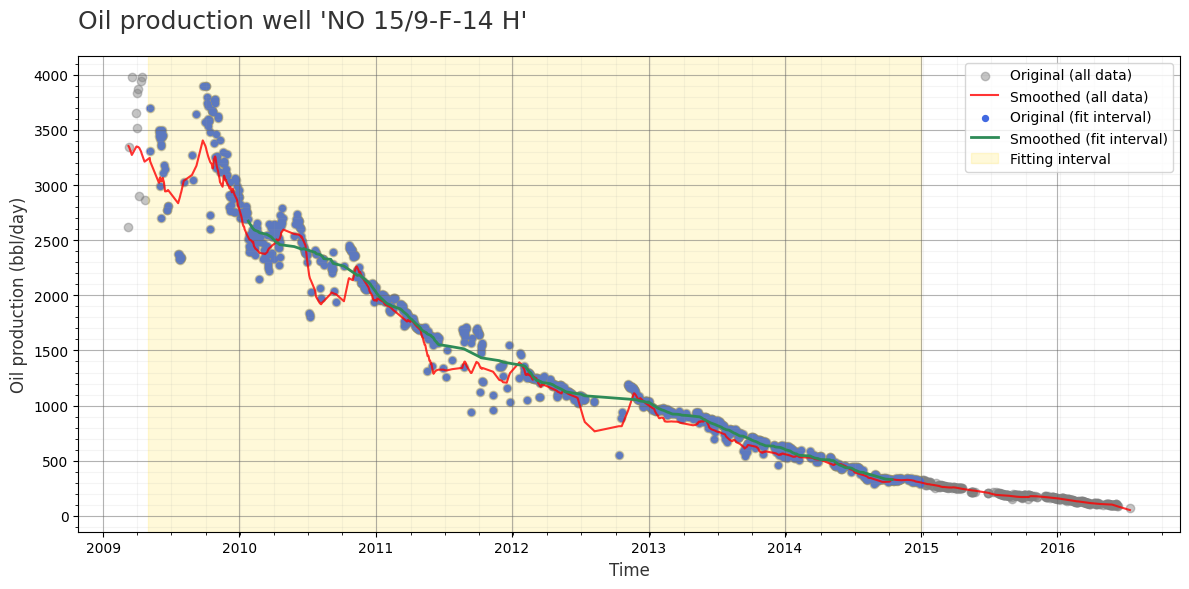

In [175]:
# --- plot: full vs fit interval (one figure) ---
plt.figure(figsize=(12, 6))

# full data
plt.scatter(df_smoothed_all["date"], df_smoothed_all["production"],
            label="Original (all data)", alpha=0.45, color="gray")
plt.plot(df_smoothed_all["date"], df_smoothed_all["production_rol_Av"],
         label="Smoothed (all data)", color="red", alpha=0.8)

# fit interval data
plt.scatter(df_fit["date"], df_fit["production"],
            label="Original (fit interval)", color="royalblue", s=18)
plt.plot(df_fit_smoothed["date"], df_fit_smoothed["production_rol_Av"],
         label="Smoothed (fit interval)", color="seagreen", linewidth=2)

# shade the fitting window
plt.axvspan(pd.to_datetime(fit_start), pd.to_datetime(fit_end),
            color="gold", alpha=0.15, label="Fitting interval")

# formatting
plt.title("Oil production well 'NO 15/9-F-14 H'", fontsize=18, color="#333", loc="left", pad=20)
plt.xlabel("Time", fontsize=12, color="#333")
plt.ylabel("Oil production (bbl/day)", fontsize=12, color="#333")
plt.grid(which="major", color="#6666", linestyle="-", alpha=.5)
plt.grid(which="minor", color="#9999", linestyle="-", alpha=.1)
plt.minorticks_on()
plt.legend()
plt.tight_layout()
plt.show()


In [176]:
arps_fit.prepocess_date_col(frequency="Daily")

In [177]:
parameters, flow_rates, best_model = arps_fit.fit_all_models()


In [178]:
parameters


,Model,Qi,Qi_std,Di,Di_std,b,b_std,Normalized RMSE
0,ex,2809.460449,8.860344,0.001036,0.000005,0.000000,0.00000,0.026480
1,hp,2809.488783,12.808892,0.001036,0.000016,0.000001,0.02096,0.026480
2,hr,3142.060617,32.870527,0.002085,0.000045,1.000000,0.00000,0.063477


In [179]:
flow_rates

,Original_Smoothed,Exponential,Hyperbolic,Harmonic,Date
Time,,,,,
0,2673.5142,2809.460449,2809.488783,3142.060617,2010-01-25
2,2660.6619,2803.642907,2803.671080,3129.013947,2010-01-27
11,2612.8899,2777.612683,2777.640134,3071.620125,2010-02-05
12,2606.6999,2774.735396,2774.762767,3065.372738,2010-02-06
13,2604.2797,2771.861088,2771.888380,3059.150712,2010-02-07
...,...,...,...,...,...
1718,330.8818,473.510786,473.501344,685.789648,2014-10-09
1719,330.7465,473.020283,473.010843,685.477737,2014-10-10
1720,330.5629,472.530288,472.520851,685.166108,2014-10-11


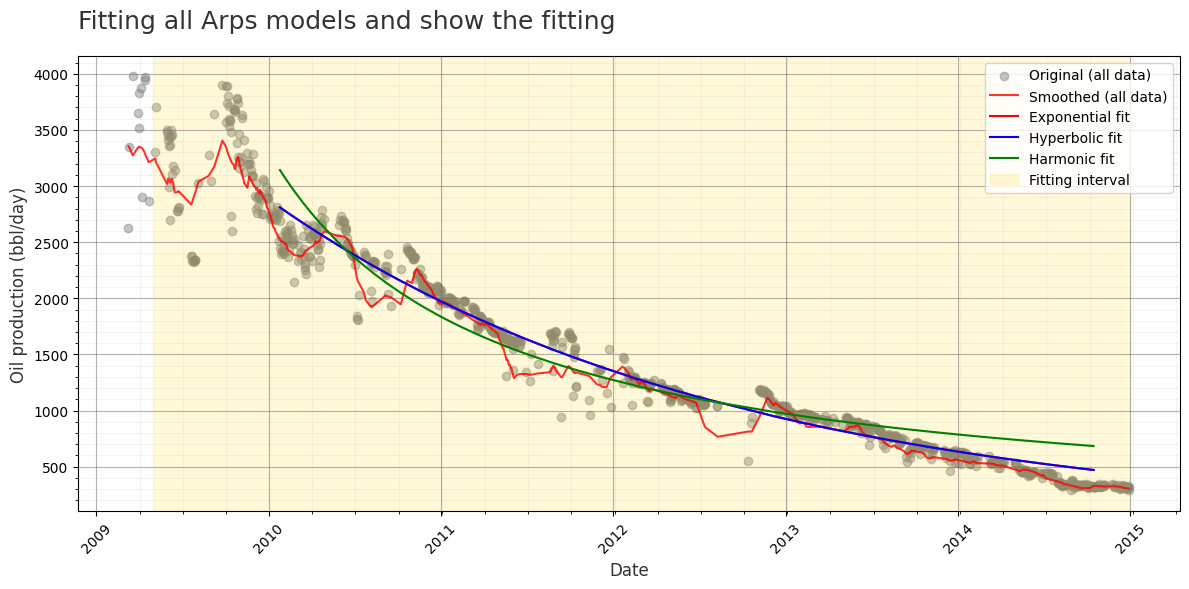

In [180]:
plt.figure(figsize=(12, 6))

# convert to datetime for slicing
fit_end_dt = pd.to_datetime(fit_end)

# --- clip datasets up to fit_end ---
df_all_clip = df_smoothed_all[df_smoothed_all["date"] <= fit_end_dt]
flow_rates_clip = flow_rates[flow_rates["Date"] <= fit_end_dt]

# full data (up to fit_end)
plt.scatter(df_all_clip["date"], df_all_clip["production"],
            label="Original (all data)", alpha=0.45, color="gray")
plt.plot(df_all_clip["date"], df_all_clip["production_rol_Av"],
         label="Smoothed (all data)", color="red", alpha=0.8)

# fitted models (up to fit_end)
plt.plot(flow_rates_clip["Date"], flow_rates_clip["Exponential"],
         label="Exponential fit", color="red")
plt.plot(flow_rates_clip["Date"], flow_rates_clip["Hyperbolic"],
         label="Hyperbolic fit", color="blue")
plt.plot(flow_rates_clip["Date"], flow_rates_clip["Harmonic"],
         label="Harmonic fit", color="green")

# shade the fitting window
plt.axvspan(pd.to_datetime(fit_start), pd.to_datetime(fit_end),
            color="gold", alpha=0.15, label="Fitting interval")

# --- formatting ---
plt.title("Fitting all Arps models and show the fitting",
          fontsize=18, color="#333", loc="left", pad=20)
plt.xlabel("Date", fontsize=12, color="#333")
plt.ylabel("Oil production (bbl/day)", fontsize=12, color="#333")

plt.grid(which="major", color="#6666", linestyle="-", alpha=.5)
plt.grid(which="minor", color="#9999", linestyle="-", alpha=.1)
plt.minorticks_on()
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
def arps_rate(t, Qi, Di, b):
    t = np.asarray(t, dtype=float)
    if np.isclose(b, 0.0):          # Exponential
        return Qi * np.exp(-Di * t)
    elif np.isclose(b, 1.0):        # Harmonic
        return Qi / (1.0 + Di * t)
    else:                           # Hyperbolic (general b)
        return Qi / np.power(1.0 + b * Di * t, 1.0 / b)

def forecast_all_models(parameters, flow_rates, start_date, end_date, is_initial: bool = True):
    f = flow_rates.copy()
    f["Date"] = pd.to_datetime(f["Date"])
    t0 = f["Date"].min()

    start_date = pd.to_datetime(start_date)
    end_date   = pd.to_datetime(end_date)
    dates = pd.date_range(start=start_date, end=end_date, freq="D")

    # relative time within the prediction window
    t_rel = (dates - start_date).days.astype(float)

    # elapsed days from original origin to the new window start
    t_start = float((start_date - t0).days)

    out = pd.DataFrame({"Date": dates})

    for _, row in parameters.iterrows():
        model = row["Model"]
        Qi, Di, b = float(row["Qi"]), float(row["Di"]), float(row["b"])

        if is_initial:
            qi_star = arps_rate(t_start, Qi, Di, b)

            if np.isclose(b, 0.0):         # exponential
                D_star = Di
            elif np.isclose(b, 1.0):       # harmonic
                D_star = Di / (1.0 + Di * t_start)
            else:                           # hyperbolic
                D_star = Di / (1.0 + b * Di * t_start)

            out[model] = arps_rate(t_rel, qi_star, D_star, b)

        else:
            out[model] = arps_rate(t_rel, Qi, Di, b)

    return out


In [ ]:
start_date = pd.to_datetime(fit_end)   # your fit_end as the new start
end_date = ""                          # user input, leave empty for default

# if user did not specify end_date → set to +2 years
if end_date == "" or end_date is None:
    end_date = start_date + pd.DateOffset(years=2)
else:
    end_date = pd.to_datetime(end_date)

print("Start:", start_date.date())
print("End:", end_date.date())

In [ ]:
forecast_df = forecast_all_models(parameters, flow_rates, start_date, end_date,is_initial=True)
forecast_df


In [ ]:
plt.figure(figsize=(12, 6))

# convert to datetime for slicing
fit_end_dt = pd.to_datetime(fit_end)

# --- clip datasets up to fit_end ---
df_all_clip = df_smoothed_all[df_smoothed_all["date"] <= fit_end_dt]
flow_rates_clip = flow_rates[flow_rates["Date"] <= fit_end_dt]

# full data (up to fit_end)
plt.scatter(df_all_clip["date"], df_all_clip["production"],
            label="Original (all data)", alpha=0.45, color="gray")
plt.plot(df_all_clip["date"], df_all_clip["production_rol_Av"],
         label="Smoothed (all data)", color="red", alpha=0.8)

# fitted + forecast models (same colors, one legend entry each)
plt.plot(flow_rates_clip["Date"], flow_rates_clip["Exponential"],
         label="Exponential", color="red")
plt.plot(forecast_df["Date"], forecast_df["ex"],
         color="red", linestyle="--", label="_nolegend_")

plt.plot(flow_rates_clip["Date"], flow_rates_clip["Hyperbolic"],
         label="Hyperbolic", color="blue")
plt.plot(forecast_df["Date"], forecast_df["hp"],
         color="blue", linestyle="--", label="_nolegend_")

plt.plot(flow_rates_clip["Date"], flow_rates_clip["Harmonic"],
         label="Harmonic", color="green")
plt.plot(forecast_df["Date"], forecast_df["hr"],
         color="green", linestyle="--", label="_nolegend_")

# shade the fitting window
plt.axvspan(pd.to_datetime(fit_start), pd.to_datetime(fit_end),
            color="gold", alpha=0.15, label="Fitting interval")

# --- formatting ---
plt.title("Arps fitting and forecasts", fontsize=18, color="#333", loc="left", pad=20)
plt.xlabel("Date", fontsize=12, color="#333")
plt.ylabel("Oil production (bbl/day)", fontsize=12, color="#333")

plt.grid(which="major", color="#6666", linestyle="-", alpha=.5)
plt.grid(which="minor", color="#9999", linestyle="-", alpha=.1)
plt.minorticks_on()
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
#inputs
n_scenarios=1000
discount_rate=.1
oil_price_mean=70
oil_price_std=10

In [181]:
# ----- Monte Carlo using forecast_all_models -----
def monte_carlo_simulation(parameters, flow_rates,
                           start_date, end_date,
                           n_scenarios=1000,
                           discount_rate=0.10,
                           price_mean=70, price_std=10,
                           is_initial=True,
                           clamp_b=(1e-6, 2.0)):
    """
    Runs scenario draws by sampling Qi/Di/b per model, then calling forecast_all_models(...)
    to produce daily rates for ex/hp/hr. Computes TotalProd and NPV per scenario.

    Notes:
      - For 'ex' and 'hr', b is forced to 0 and 1 respectively (ignores b_std).
      - If *_std columns are missing, sampling falls back to the mean (std=0).
      - Discounting starts at the forecast window start_date.
    """
    # Time axis for the cashflow window
    start_date = pd.to_datetime(start_date)
    end_date   = pd.to_datetime(end_date)
    dates = pd.date_range(start=start_date, end=end_date, freq="D")
    n_steps = len(dates)
    # discount factors relative to the forecast start
    t_rel_days = np.arange(n_steps, dtype=float)
    discount_factors = 1.0 / np.power((1.0 + discount_rate), t_rel_days / 365.0)

    # Helper to safely read std columns (fallback to 0 if missing)
    def _get_std(df, model, colname):
        try:
            v = float(df.loc[df["Model"] == model, colname].values[0])
            return max(v, 0.0)
        except Exception:
            return 0.0

    models = ["ex", "hp", "hr"]
    # Storage
    results = {m: {"TotalProd": [], "NPV": []} for m in models}

    for _ in range(n_scenarios):
        # Price scenario (daily)
        price_path = np.random.normal(price_mean, price_std, n_steps)

        # Draw parameter set for this scenario
        params_draw = parameters.copy(deep=True)

        for m in models:
            # Means
            Qi_mu = float(params_draw.loc[params_draw["Model"] == m, "Qi"].values[0])
            Di_mu = float(params_draw.loc[params_draw["Model"] == m, "Di"].values[0])
            b_mu  = float(params_draw.loc[params_draw["Model"] == m, "b" ].values[0])

            # STDs (fallback to 0 if not present)
            Qi_std = _get_std(params_draw, m, "Qi_std")
            Di_std = _get_std(params_draw, m, "Di_std")
            b_std  = _get_std(params_draw, m, "b_std")

            # Sample
            Qi = np.random.normal(Qi_mu, Qi_std)
            Di = np.random.normal(Di_mu, Di_std)

            # Enforce valid positives
            Qi = max(Qi, 1e-8)
            Di = max(Di, 1e-10)

            # b handling
            if m == "ex":
                b = 0.0
            elif m == "hr":
                b = 1.0
            else:  # "hp"
                b = np.random.normal(b_mu, b_std)
                # clamp to reasonable range
                b = float(np.clip(b, clamp_b[0], clamp_b[1]))

            # Write back the draw
            params_draw.loc[params_draw["Model"] == m, ["Qi", "Di", "b"]] = [Qi, Di, b]

        # Forecast rates for this scenario (daily)
        scen_forecast = forecast_all_models(
            params_draw, flow_rates,
            start_date=start_date, end_date=end_date,
            is_initial=is_initial
        )
        # scen_forecast columns: ["Date","ex","hp","hr"]

        # Cashflow & metrics per model
        for m in models:
            q = scen_forecast[m].to_numpy(float)  # bbl/day
            total_prod = float(np.trapz(q, dx=1.0))  # bbl over window
            revenues = q * price_path               # $/day
            npv = float(np.sum(revenues * discount_factors))

            results[m]["TotalProd"].append(total_prod)
            results[m]["NPV"].append(npv)

    # Pack to DataFrame
    out = {}
    for m in models:
        out[f"{m}_TotalProd"] = results[m]["TotalProd"]
        out[f"{m}_NPV"]       = results[m]["NPV"]
    return pd.DataFrame(out)


In [182]:
# ---------------- example usage ----------------
# forecast 1000 scenarios from 2010-01-01 to 2015-12-31
mc_results = monte_carlo_simulation(
    parameters=parameters,
    flow_rates=flow_rates,
    start_date=start_date,
    end_date=end_date,
    n_scenarios=n_scenarios,
    discount_rate=discount_rate,
    price_mean=oil_price_mean, price_std=oil_price_std
)

# mc_results now has columns like:
# ['ex_TotalProd','ex_NPV','hp_TotalProd','hp_NPV','hr_TotalProd','hr_NPV']

C:\Users\abshahin\AppData\Local\Temp\ipykernel_20356\78516982.py:89: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_prod = float(np.trapz(q, dx=1.0))  # bbl over window
C:\Users\abshahin\AppData\Local\Temp\ipykernel_20356\78516982.py:89: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_prod = float(np.trapz(q, dx=1.0))  # bbl over window
C:\Users\abshahin\AppData\Local\Temp\ipykernel_20356\78516982.py:89: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_prod = float(np.trapz(q, dx=1.0))  # bbl over window
C:\Users\abshahin\AppData\Local\Temp\ipykernel_20356\78516982.py:89: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate

In [183]:
mc_results

,ex_TotalProd,ex_NPV,hp_TotalProd,hp_NPV,hr_TotalProd,hr_NPV
0,221994.768466,1.429385e+07,224753.909034,1.447070e+07,430266.374627,2.749054e+07
1,220100.360715,1.424040e+07,222219.112545,1.437671e+07,422185.643406,2.712859e+07
2,219531.975436,1.430313e+07,233349.506976,1.519438e+07,419959.103640,2.715969e+07
3,218407.332385,1.409545e+07,231929.822512,1.496369e+07,407271.454989,2.609151e+07
4,223121.463838,1.434834e+07,225585.956378,1.450581e+07,432885.610486,2.763621e+07
...,...,...,...,...,...,...
995,224237.858680,1.467563e+07,239567.065098,1.567203e+07,427587.951929,2.775682e+07
996,220502.318615,1.431839e+07,216761.594010,1.407504e+07,433660.032954,2.793856e+07
997,222072.383942,1.447061e+07,229106.185943,1.492581e+07,416623.351728,2.690442e+07
998,217781.322665,1.421318e+07,228070.443295,1.488133e+07,417412.817383,2.700587e+07


In [184]:
def summarize_and_plot(mc_results, model, metric="TotalProd"):
    """
    Plot histogram + CDF for a given model and metric (TotalProd or NPV).
    Adds vertical lines for mean, P10, P90.
    """
    # extract the column
    col = f"{model}_{metric}"
    data = mc_results[col].values

    # compute stats
    mean_val = np.mean(data)
    p10 = np.percentile(data, 10)
    p90 = np.percentile(data, 90)

    # histogram
    plt.figure(figsize=(10,5))
    plt.hist(data, bins=30, alpha=0.7, color="skyblue", edgecolor="k")
    plt.axvline(mean_val, color="red", linestyle="--", label=f"Mean: {mean_val:,.0f}")
    plt.axvline(p10, color="green", linestyle="--", label=f"P10: {p10:,.0f}")
    plt.axvline(p90, color="blue", linestyle="--", label=f"P90: {p90:,.0f}")
    plt.title(f"Histogram of {col}", fontsize=14)
    plt.xlabel(metric)
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    # cumulative distribution
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(sorted_data)+1) / len(sorted_data)

    plt.figure(figsize=(10,5))
    plt.plot(sorted_data, cdf, color="black")
    plt.axvline(mean_val, color="red", linestyle="--", label=f"Mean: {mean_val:,.0f}")
    plt.axvline(p10, color="green", linestyle="--", label=f"P10: {p10:,.0f}")
    plt.axvline(p90, color="blue", linestyle="--", label=f"P90: {p90:,.0f}")
    plt.title(f"CDF of {col}", fontsize=14)
    plt.xlabel(metric)
    plt.ylabel("Cumulative Probability")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    return {"mean": mean_val, "P10": p10, "P90": p90}




In [ ]:
# ---------------- Example usage ----------------
# For exponential model - Total Production
summary_ex_prod = summarize_and_plot(mc_results, "ex", "TotalProd")

# For exponential model - NPV
summary_ex_npv = summarize_and_plot(mc_results, "ex", "NPV")

# Repeat with "hp" or "hr" for other models

In [ ]:
# ---------------- Example usage ----------------
# For exponential model - Total Production
summary_ex_prod = summarize_and_plot(mc_results, "hp", "TotalProd")

# For exponential model - NPV
summary_ex_npv = summarize_and_plot(mc_results, "hp", "NPV")

# Repeat with "hp" or "hr" for other models

In [ ]:
# ---------------- Example usage ----------------
# For exponential model - Total Production
summary_ex_prod = summarize_and_plot(mc_results, "hr", "TotalProd")

# For exponential model - NPV
summary_ex_npv = summarize_and_plot(mc_results, "hr", "NPV")

# Repeat with "hp" or "hr" for other models

In [ ]:
def two_segment_preview_all_models(parameters, flow_rates,
                                   start_date, split_date, end_date,
                                   chosen_model,      # "ex" | "hp" | "hr"
                                   user_Qi_mean, user_Di_mean, user_b_mean):
    """
    Segment 1 (start_date → split_date):
        - Use fitted parameters
        - is_initial=True (restart at start_date)

    Segment 2 (split_date → end_date):
        - Override the chosen model with user means
        - is_initial=False (use new params but keep elapsed-time handling from forecast_all_models)
        - Return only the chosen model for the post-split part, as '<model>_after'
    """
    # --- normalize inputs
    start_date = pd.to_datetime(start_date)
    split_date = pd.to_datetime(split_date)
    end_date   = pd.to_datetime(end_date)

    # ---------- Segment 1: fitted params, is_initial = True ----------
    seg1 = forecast_all_models(parameters, flow_rates,
                               start_date=start_date,
                               end_date=split_date,
                               is_initial=True)   # all three models

    # ---------- Segment 2: user overrides for chosen model, is_initial = False ----------
    # copy parameters and replace the chosen model row with user means
    params2 = parameters.copy()

    # enforce canonical b for exp/harm
    if chosen_model == "ex":
        user_b_mean = 0.0
    elif chosen_model == "hr":
        user_b_mean = 1.0

    params2.loc[params2["Model"] == chosen_model, ["Qi", "Di", "b"]] = [
        float(user_Qi_mean), float(user_Di_mean), float(user_b_mean)
    ]

    seg2 = forecast_all_models(params2, flow_rates,
                               start_date=split_date,
                               end_date=end_date,
                               is_initial=False)  # only keep chosen model

    # ---------- Build combined preview ----------
    # pre-split: ex/hp/hr, NaNs for post rows
    pre = seg1[["Date", "ex", "hp", "hr"]].copy()
    pre_post_pad = pd.DataFrame({
        "Date": seg2["Date"],
        "ex":  np.nan, "hp": np.nan, "hr": np.nan
    })

    # post-split: chosen model as '<model>_after', NaNs for pre rows
    post_only = pd.DataFrame({
        "Date": seg2["Date"],
        f"{chosen_model}_after": seg2[chosen_model].values
    })
    pre_only_pad = pd.DataFrame({
        "Date": seg1["Date"],
        f"{chosen_model}_after": np.nan
    })

    # concatenate with aligned columns
    left  = pd.concat([pre, pre_post_pad], ignore_index=True)
    right = pd.concat([pre_only_pad, post_only], ignore_index=True)

    out = left.merge(right, on="Date", how="inner")

    return out


In [ ]:
# ---------- Example usage ----------
# inputs you already have:
# parameters, flow_rates, fit_end -> start_date
start_date = pd.to_datetime(fit_end)
end_date = start_date + pd.DateOffset(years=2)
split_date = start_date + pd.DateOffset(months=12)

# user chooses which model to take over after the split + its parameters
# --- user inputs ---
chosen_model = "hp"     # "ex", "hp", or "hr"

# means
user_Qi_mean = 500.0
user_Di_mean = 0.0010
user_b_mean  = 0.65     # ignored if chosen_model is "ex" or "hr"

# std deviations
user_Qi_std  = 50.0
user_Di_std  = 0.0002
user_b_std   = 0.05

In [ ]:
preview = two_segment_preview_all_models(
    parameters, flow_rates,
    start_date=start_date,
    split_date=split_date,
    end_date=end_date,
    chosen_model="hp",
    user_Qi_mean=user_Qi_mean,
    user_Di_mean=user_Di_mean,
    user_b_mean=user_b_mean,    # ignored internally for 'ex'/'hr' (forced to 0/1)
)

# ---------- Plot ----------
plt.figure(figsize=(12,6))

# original smoothed up to end_date (optional for context)
mask_ctx = (flow_rates["Date"] >= start_date) & (flow_rates["Date"] <= end_date)
plt.plot(flow_rates.loc[mask_ctx,"Date"], flow_rates.loc[mask_ctx,"Original_Smoothed"],
         label="Original (smoothed)", color="black", linewidth=2, alpha=.7)

# pre-split fitted curves (solid)
colors = {"ex":"red", "hp":"blue", "hr":"green"}
for m in ["ex","hp","hr"]:
    plt.plot(preview["Date"], preview[m], color=colors[m], label=f"{m.upper()} (pre)", linewidth=1.8)

# post-split chosen model (dashed)
plt.plot(preview["Date"], preview[f"{chosen_model}_after"],
         color=colors[chosen_model], linestyle="--", linewidth=2.2,
         label=f"{chosen_model.upper()} (post, user)")

# markers for split + shade whole prediction window
plt.axvline(split_date, color="#444", linestyle="--", alpha=.6, label="Split date")
plt.axvspan(start_date, end_date, color="gold", alpha=.10, label="Prediction window")

plt.title("Two-segment forecast: all models before split, chosen model after", loc="left", fontsize=16)
plt.xlabel("Date"); plt.ylabel("Oil rate (bbl/day)")
plt.grid(alpha=.3); plt.legend(); plt.tight_layout(); plt.show()

In [ ]:
def monte_carlo_two_segment_simulation(
    parameters, flow_rates,
    start_date, split_date, end_date,
    n_scenarios=1000,
    discount_rate=0.10,
    price_mean=70, price_std=10,
    clamp_b=(1e-6, 2.0),
    seg2_overrides=None  # e.g. {"hp": (Qi_mu, Di_mu, b_mu, Qi_std, Di_std, b_std)} or {"hp": (Qi,Di,b)}
):
    """
    Two-segment Monte Carlo using forecast_all_models(...) twice per scenario.

    Segment 1: [start_date, split_date]   with is_initial=True  -> use each model's own curve.
    Segment 2: [split_date, end_date]     with is_initial=False -> use ONLY the overridden model's curve for ALL models.

    seg2_overrides:
      - dict with EXACTLY one key in {'ex','hp','hr'}.
      - 3-tuple  (Qi, Di, b)   => fixed values in segment 2 (for that model).
      - 6-tuple  (Qi_mu, Di_mu, b_mu, Qi_std, Di_std, b_std) => sample per scenario in segment 2 (for that model).
      - For 'ex' and 'hr', b is forced to 0 or 1 regardless of what's passed.

    Returns a DataFrame with columns:
      ['ex_TotalProd','ex_NPV','hp_TotalProd','hp_NPV','hr_TotalProd','hr_NPV']
    """
    import numpy as np
    import pandas as pd

    # --- time axes ---
    start_date = pd.to_datetime(start_date)
    split_date = pd.to_datetime(split_date)
    end_date   = pd.to_datetime(end_date)

    dates_full = pd.date_range(start=start_date, end=end_date, freq="D")
    n_full = len(dates_full)

    # discount factors from forecast window start
    t_rel_days = np.arange(n_full, dtype=float)
    discount_factors = 1.0 / np.power((1.0 + discount_rate), t_rel_days/365.0)

    models = ["ex", "hp", "hr"]
    results = {m: {"TotalProd": [], "NPV": []} for m in models}

    # ---- validate & normalize overrides: exactly ONE model must be specified (or None) ----
    override_key = None
    override_spec = None
    if seg2_overrides is not None:
        if not isinstance(seg2_overrides, dict) or len(seg2_overrides) != 1:
            raise ValueError("seg2_overrides must be a dict with EXACTLY one key among {'ex','hp','hr'}.")
        (override_key, override_spec), = seg2_overrides.items()
        if override_key not in models:
            raise ValueError(f"Invalid override key '{override_key}'. Must be one of {models}.")
        if not isinstance(override_spec, (tuple, list)) or len(override_spec) not in (3, 6):
            raise ValueError(
                f"Override for '{override_key}' must be a 3-tuple (Qi,Di,b) or "
                f"6-tuple (Qi_mu,Di_mu,b_mu,Qi_std,Di_std,b_std)."
            )

    def _get_std(df, model, col):
        try:
            v = float(df.loc[df["Model"] == model, col].values[0])
            return max(v, 0.0)
        except Exception:
            return 0.0

    for _ in range(n_scenarios):
        # price path over the whole window
        price_path = np.random.normal(price_mean, price_std, n_full)

        # --- draw base params for this scenario (used in seg1; also default seg2) ---
        params_draw = parameters.copy(deep=True)
        for m in models:
            Qi_mu = float(params_draw.loc[params_draw["Model"] == m, "Qi"].values[0])
            Di_mu = float(params_draw.loc[params_draw["Model"] == m, "Di"].values[0])
            b_mu  = float(params_draw.loc[params_draw["Model"] == m, "b" ].values[0])

            Qi_std = _get_std(params_draw, m, "Qi_std")
            Di_std = _get_std(params_draw, m, "Di_std")
            b_std  = _get_std(params_draw, m, "b_std")

            Qi = max(np.random.normal(Qi_mu, Qi_std), 1e-8)
            Di = max(np.random.normal(Di_mu, Di_std), 1e-10)

            if m == "ex":
                b = 0.0
            elif m == "hr":
                b = 1.0
            else:
                b = np.random.normal(b_mu, b_std)
                b = float(np.clip(b, clamp_b[0], clamp_b[1]))

            params_draw.loc[params_draw["Model"] == m, ["Qi", "Di", "b"]] = [Qi, Di, b]

        # --- Segment 1 forecast (restart) ---
        seg1 = forecast_all_models(
            params_draw, flow_rates,
            start_date=start_date, end_date=split_date,
            is_initial=True
        )  # columns: Date, ex, hp, hr

        # --- Segment 2 params (apply override to the single chosen model, if any) ---
        params_seg2 = params_draw.copy(deep=True)
        if override_key is not None:
            m = override_key
            spec = override_spec
            if len(spec) == 3:
                Qi2, Di2, b2 = map(float, spec)
            else:  # len == 6  (mean,std sampling per scenario)
                Qi_mu2, Di_mu2, b_mu2, Qi_sd2, Di_sd2, b_sd2 = map(float, spec)
                Qi2 = max(np.random.normal(Qi_mu2, Qi_sd2), 1e-8)
                Di2 = max(np.random.normal(Di_mu2, Di_sd2), 1e-10)
                if m == "ex":
                    b2 = 0.0
                elif m == "hr":
                    b2 = 1.0
                else:
                    b2 = np.random.normal(b_mu2, b_sd2)
                    b2 = float(np.clip(b2, clamp_b[0], clamp_b[1]))
            # enforce canonical b for exp/harm regardless
            if m == "ex": b2 = 0.0
            if m == "hr": b2 = 1.0
            params_seg2.loc[params_seg2["Model"] == m, ["Qi","Di","b"]] = [Qi2, Di2, b2]

        # --- Segment 2 forecast (continue) ---
        seg2 = forecast_all_models(
            params_seg2, flow_rates,
            start_date=split_date, end_date=end_date,
            is_initial=False
        )  # columns: Date, ex, hp, hr

        # ===================== STITCHING FOR METRICS =====================
        # Base = pre-split (seg1) on full index; seg1 will be NaN after split
        pre = seg1.set_index("Date").reindex(dates_full)

        if override_key is None:
            # No special override → normal stitch (seg2 wins at split)
            merged = pd.concat([seg1, seg2], ignore_index=True).drop_duplicates("Date", keep="last")
            merged = merged.set_index("Date").reindex(dates_full).interpolate(limit_direction="both")
            # metrics per model
            for m in models:
                q = merged[m].to_numpy(float)
                total_prod = float(np.trapz(q, dx=1.0))
                revenues   = q * price_path
                npv        = float(np.sum(revenues * discount_factors))
                results[m]["TotalProd"].append(total_prod)
                results[m]["NPV"].append(npv)
        else:
            # Build the single override series from seg2 for the chosen model
            override_series = (
                seg2.set_index("Date")[override_key]
                    .reindex(dates_full)
                    .astype(float)
            )
            # For each model: use its seg1 curve before split; use override_series after split
            for m in models:
                series_pre = pre[m].astype(float)
                q_series = series_pre.fillna(override_series)  # <- key: post-split = override only
                q = q_series.to_numpy(float)
                total_prod = float(np.trapz(q, dx=1.0))
                revenues   = q * price_path
                npv        = float(np.sum(revenues * discount_factors))
                results[m]["TotalProd"].append(total_prod)
                results[m]["NPV"].append(npv)
        # ================================================================

    # pack results
    out = {}
    for m in models:
        out[f"{m}_TotalProd"] = results[m]["TotalProd"]
        out[f"{m}_NPV"]       = results[m]["NPV"]
    return pd.DataFrame(out)


In [ ]:
# Format: (Qi_mean, Di_mean, b_mean, Qi_std, Di_std, b_std)
seg2_overrides = {
    chosen_model: (
        user_Qi_mean, user_Di_mean, user_b_mean,
        user_Qi_std,  user_Di_std,  user_b_std
    )
}

# --- window setup ---
start_date = pd.to_datetime(fit_end)
split_date = start_date + pd.DateOffset(months=12)
end_date   = start_date + pd.DateOffset(years=2)

# --- run two-segment MC ---
mc_two_seg = monte_carlo_two_segment_simulation(
    parameters=parameters,
    flow_rates=flow_rates,
    start_date=start_date,
    split_date=split_date,
    end_date=end_date,
    n_scenarios=1000,
    discount_rate=0.10,
    price_mean=70, price_std=10,
    seg2_overrides=seg2_overrides
)



In [ ]:
# --- summarize chosen model results ---
summary_prod = summarize_and_plot(mc_two_seg, "hr", "TotalProd")
summary_npv  = summarize_and_plot(mc_two_seg, "hr", "NPV")

print(f"{chosen_model.upper()} TotalProd:", summary_prod)
print(f"{chosen_model.upper()} NPV:", summary_npv)